# Mapping of Mesonet Clouds onto Grid Structure
**Problem definition:** Given a set of measurements from a group of arbitrarily scattered Mesonets, find an appropriate mapping of these measurements onto a regular 2-D space (e.g. grid). The final mapping will be used as an input to a CNN, therefore it is important to preserve as much information as possible.

**Approach:** Employ Delaunay triangulation based barycentric interpolation for mapping onto a grid of given dimensions. Then, use a matrix completion method to impute the points outside of the convex hull of the triangulation.

**Specify the grid and figure dimensions by altering the variables below, and running the cell.**

In [0]:
grid_size = [5, 13]
fig_size = (30, 15)

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)


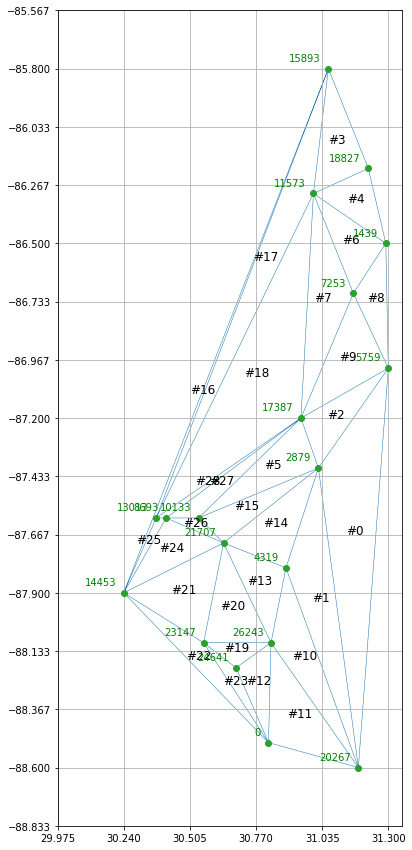

In [40]:
#@title This code cell defines the input data, generates and plots the delaunay triangulation.
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from PIL import *
import pandas as pd
import matplotlib.ticker as plticker
import seaborn as sns
!pip install -U scikit-learn

# using the 19 points from Dr. Tzeng's email.
points = np.array([
[31.3, -87], [31.29, -86.5], [31.22, -86.2], [31.18, -88.6],
[31.16, -86.7], [31.06, -85.8], [31.02, -87.4], [31, -86.3], 
[30.95, -87.2], [30.89, -87.8], [30.83, -88.1], [30.82, -88.5], 
[30.69, -88.2], [30.64, -87.7], [30.56, -88.1], [30.54, -87.6], 
[30.41, -87.6], [30.37, -87.6], [30.24, -87.9]
])
values = np.array([5759, 1439, 18827, 20267, 7253, 15893, 2879, 11573, 17387, 
                   4319, 26243, 0, 24641, 21707, 23147, 10133, 8693, 13013, 14453])

norm = np.linalg.norm(values)
norm_values = values / norm

# add the values for each coordinate, and format the data
df = pd.DataFrame(data=points)
df.columns = ['X', 'Y']
df['val'] = values # from the excel sheet
df['norm_val'] = norm_values
x_range, y_range = df.X.max() - df.X.min(), df.Y.max() - df.Y.min()

# plot the triangulation
tri = Delaunay(points, incremental=True)
fig = plt.figure(figsize=fig_size) # 12 x 7 
ax = fig.add_subplot(1, 1, 1)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), linewidth=0.5)
plt.plot(points[:,0], points[:,1], 'o')

for j, s in enumerate(tri.simplices):
  p = points[s].mean(axis=0)
  plt.text(p[0], p[1], '#%d' % j, ha='center', size=12) # label triangles
for j, p in enumerate(points):
  plt.text(p[0]-0.03, p[1]+0.03, values[j], ha='right', size=10, color='green') # label the points with values

# Add the grid
x_ticks = np.arange(df.X.min() - (x_range/(grid_size[0] - 1)), df.X.max() + (x_range/(grid_size[0] - 1)), (x_range/(grid_size[0] - 1)))
y_ticks = np.arange(df.Y.min() - (y_range/(grid_size[1] - 1)), df.Y.max() + (y_range/(grid_size[1] - 1)), (y_range/(grid_size[1] - 1)))
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_aspect('equal')
ax.grid()
plt.show()

# find which triangle the given list of (arbitrary) points are in
# query_points = np.array([(31, -88), (30.5, -88)])
# print(tri.find_simplex(query_points))

# find which triangles a given vertex of the triangulation contributes to
# point_index = 6 # 7th point in the points list provided
#[i for i,s in enumerate(tri.simplices) if point_index in s]

Ranges of X and Y dimensions: 1.0600000000000023, 2.799999999999997


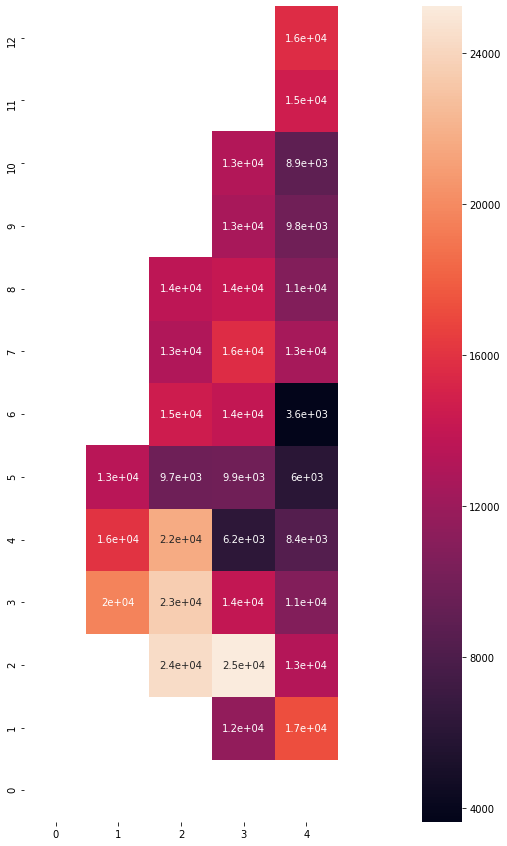

In [41]:
#@title This code cell maps the input data onto a grid by doing interpolations on the triangulation.
# transform the point cloud onto a grid using linear barycentric interpolations relative to the delaunay triangles.
print('Ranges of X and Y dimensions: '+ str(x_range) + ', ' + str(y_range))
grid_x, grid_y = np.mgrid[df.X.min():df.X.max():(x_range/float(grid_size[0])), 
                          df.Y.min():df.Y.max():(y_range/float(grid_size[1]))]

# use normalized data for interpolation, then upscale
points, values = df[['X','Y']].values, df['norm_val'].values 

# interpolate onto the grid. method='nearest' or 'cubic' are other options
grid_linear = griddata(points, values, (grid_x, grid_y), method='linear', rescale=False)
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(grid_linear.T * norm, annot=True, ax = ax, square=True)
ax.invert_yaxis() # heatmap reverses the y axis automatically, fix it with this


In [42]:
#@title This code cell puts the interpolated grid into a dataframe and visualizes the exact values.

# show the values of the upscaled final grid, with their coordinates. 
# nan's are the points that can't be interpolated (outside of the convex hull)
final_grid = pd.DataFrame(data=grid_linear.T * norm)
final_grid.columns = grid_x[:, 0]
final_grid.index = grid_y[0, :]
final_grid = final_grid.iloc[::-1] # recover the order of rows
final_grid

,30.240,30.452,30.664,30.876,31.088
-86.015385,NaN,NaN,NaN,NaN,15686.292899
-86.230769,NaN,NaN,NaN,NaN,14619.393491
-86.446154,NaN,NaN,NaN,13156.392405,8872.920879
-86.661538,NaN,NaN,NaN,12612.256451,9813.417261
-86.876923,NaN,NaN,13720.240506,14152.908612,10773.164951
-87.092308,NaN,NaN,13048.966350,15693.560772,12562.671024
-87.307692,NaN,NaN,14589.618511,13994.360000,3631.710154
-87.523077,NaN,13485.676249,9741.385455,9855.853914,6005.162462
-87.738462,NaN,16013.323077,21618.979487,6233.504016,8378.614769
-87.953846,NaN,19581.184615,23478.200000,13977.720000,10765.326154


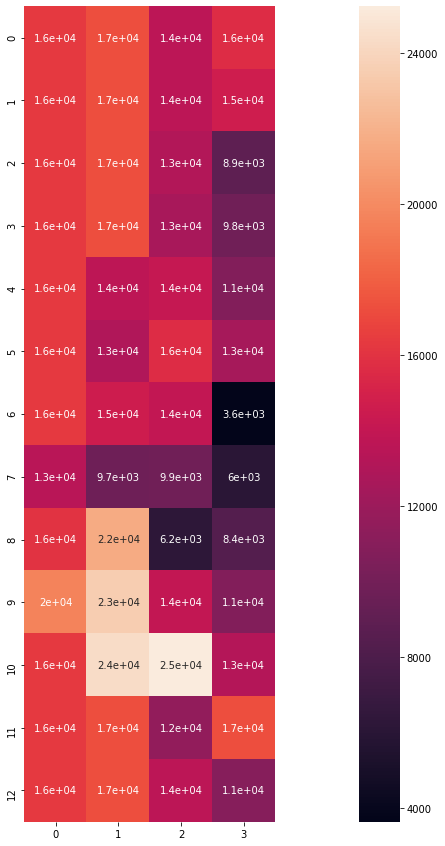

In [45]:
#@title This code cell imputes the interpolated grid by using a mean imputer.
# impute missing values using means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
imputer = imputer.fit(final_grid)
complete_grid = imputer.transform(final_grid)
complete_grid = pd.DataFrame(data=complete_grid)
#print(complete_grid) # the first column is gone because it is all NaNs and its next columns is also mostly NaNs.
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(complete_grid, annot=True, ax = ax, square=True)
#ax.invert_yaxis() # heatmap reverses the y axis automatically, fix it by doing this

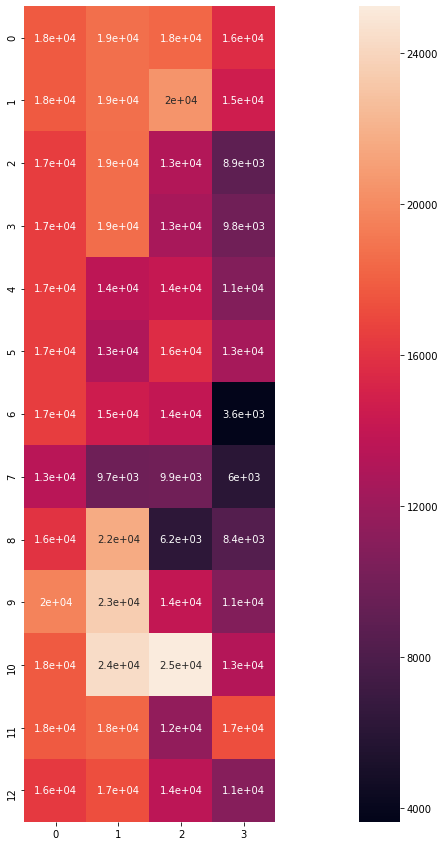

In [46]:
#@title This code cell imputes the interpolated grid by using a KNN imputer.
# using the values of nearest neighbors
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
imputer = imputer.fit(final_grid)
complete_grid = imputer.transform(final_grid)
complete_grid = pd.DataFrame(data=complete_grid)
#print(complete_grid) # the first column is gone because it is all NaNs and its next columns is also mostly NaNs.
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(complete_grid, annot=True, ax = ax, square=True)

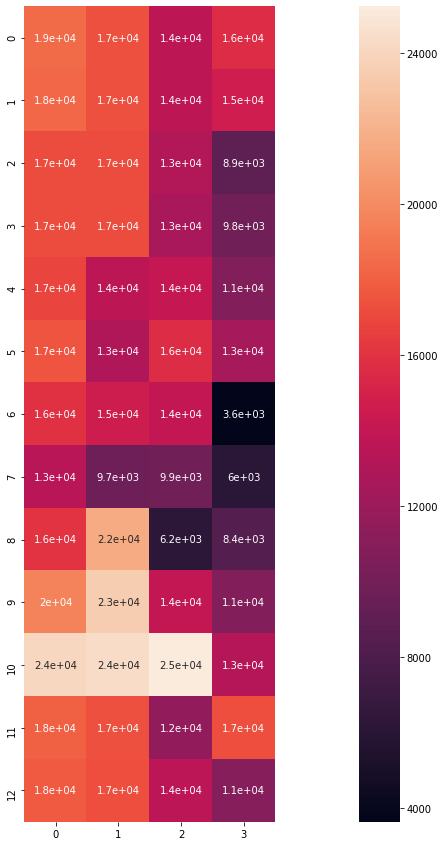

In [47]:
#@title This code cell imputes the interpolated grid by using an Interative imputer.
'''A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, 
and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the 
other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. 
This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. 
The results of the final imputation round are returned (https://scikit-learn.org/stable/modules/impute.html#iterative-imputer).''' 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=100, random_state=0)
imputer = imputer.fit(final_grid)
complete_grid = imputer.transform(final_grid)
complete_grid = pd.DataFrame(data=complete_grid)
#print(complete_grid) # the first column is gone because it is all NaNs and its next columns is also mostly NaNs.
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(complete_grid, annot=True, ax = ax, square=True)

# Testing the Generated Mapping
We attempt to test the quality of generateds mapping by employing a n-fold cross-validation strategy. 

Specifically, for a given number of rounds (folds), we drop random points from the initial set of 19 points and try to estimate their values using the \[triangulate, interpolate, impute\] strategy we have followed above.

For reproducibility and consistency, we fix the random seeds.

Since we don't  have real data, we use arbitrary values for measurements.

In [0]:
#@title Define utility functions to simplify the main loop.

def get_delaunay_grid(coordinates, values, method='linear', normalize=False):
  # format data for easy processing
  df_use = pd.DataFrame(data=use_coord)
  df_use.columns = ['X', 'Y']
  df_use['val'] = use_val
  norm = np.linalg.norm(use_val)
  norm_values = use_val / norm
  df_use['norm_val'] = norm_values
  x_range, y_range = df_use.X.max() - df_use.X.min(), df_use.Y.max() - df_use.Y.min()
  # transform the point cloud onto a grid using linear barycentric interpolations relative to the delaunay triangles.
  grid_x, grid_y = np.mgrid[df_use.X.min():df_use.X.max():(x_range/float(grid_size[0])), 
                            df_use.Y.min():df_use.Y.max():(y_range/float(grid_size[1]))]
  # use normalized data for interpolation, then upscale
  points, vals = df_use[['X','Y']].values, df_use['norm_val'].values 
  # interpolate onto the grid. method='nearest' or 'cubic' are other options
  grid_linear = griddata(points, vals, (grid_x, grid_y), method=method, rescale=False)
  if normalize: return grid_linear
  return norm * grid_linear


def get_imputer(imputer_type):
  if imputer_type == 'knn': 
    imputer = KNNImputer(n_neighbors=2)
  elif imputer_type == 'mean': 
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0)
  elif imputer_type == 'iterative':
    imputer = IterativeImputer(max_iter=50, random_state=0)
  else: return -1
  return imputer

In [0]:
# Set the number of folds, repeats and type of the imputer to fill the missing values outside the convex hull.
n_folds = 5
n_repeats = 5
imputer_type = 'mean' # 'mean', 'iterative' are other options

In [50]:
#@title Run k-fold cross-validation by randomly removing some mesonets. Calculate the mean absolute error.
np.random.seed(0)
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
rkf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats) # use 1st to estimate 2nd

points = np.array([
[31.3, -87], [31.29, -86.5], [31.22, -86.2], [31.18, -88.6],
[31.16, -86.7], [31.06, -85.8], [31.02, -87.4], [31, -86.3], 
[30.95, -87.2], [30.89, -87.8], [30.83, -88.1], [30.82, -88.5], 
[30.69, -88.2], [30.64, -87.7], [30.56, -88.1], [30.54, -87.6], 
[30.41, -87.6], [30.37, -87.6], [30.24, -87.9]
])
values = np.array([5759, 1439, 18827, 20267, 7253, 15893, 2879, 11573, 17387, 
                   4319, 26243, 0, 24641, 21707, 23147, 10133, 8693, 13013, 14453])

prediction_list = []
mae_list = []
round_settings = [] # all data to plot a round
counter = 0

for use_idx, pred_idx in rkf.split(points):
  use_coord, pred_coord = points[use_idx], points[pred_idx]
  use_val, pred_val = values[use_idx], values[pred_idx]
  grid = get_delaunay_grid(use_coord, use_val)
  grid[-1, 0] = 1e-10 # otherwise imputer truncates values

  imputer = get_imputer(imputer_type)
  imputer = imputer.fit(grid)
  full_grid = imputer.transform(grid)
  
  # for each pred coord
  predictions = []
  for pred in pred_coord:
    x_idx = min(range(len(grid_x[:,0])), key=lambda i: abs(grid_x[:,0][i]-pred[0]))
    y_idx = min(range(len(grid_y[0,:])), key=lambda i: abs(grid_y[0,:][i]-pred[1]))
    predictions.append(full_grid[x_idx, y_idx])

  # calculate the mean absolute error for the fold
  mae = mean_absolute_error(pred_val, predictions)
  mae_list.append(mae)
  # save data to plot
  round_settings.append({
      'round': counter,
      'given_coordinates': use_coord,
      'given_values': use_val,
      'estimated_coordinates': pred_coord,
      'ground_truths': pred_val,
      'estimations': predictions,
      'mae': mae
  })

print("Mean absolute error over " +str(n_folds*n_repeats) + " random trials w/ " + str(imputer_type) + " imputer: " + str(np.mean(mae_list)))

Mean absolute error over 25 random trials w/ mean imputer: 5958.775629242575


# Visualizing the Predictions
- We now try to visualize what happened in our k-fold cross-validation.
- In the experiment we defined above, each round (or fold) represents a different *question* to the model. 
- Specifically on each round we repeat the following steps: 
  1. We remove a random subset (assume 4) of the 19 points.
  2. With the remaining 15 points, we generate a triangulation.
  3. Using the triangulation, we map the measurements on the 15 points onto a grid.
  4. Then, we ask the grid to estimate the 4 values we have previously removed, based on their coordinates.
  5. The grid estimates the value at each new location by returning the value of the corresponding grid cell that is closest the given new location.
  6. We then measure the error of the prediction by taking the absolute difference between the original value and the grid's prediction.


In [0]:
#@title Define the plotting function.
def plot_estimation(round_setting):
  given_coordinates = round_setting['given_coordinates']
  estimated_coordinates = round_setting['estimated_coordinates']
  given_values = round_setting['given_values']
  ground_truths = round_setting['ground_truths']
  estimations = round_setting['estimations']
  mae = round_setting['mae']
  fig = plt.figure(figsize=fig_size) # 12 x 7 
  ax = fig.add_subplot(1, 1, 1)
  plt.plot(given_coordinates[:,0], given_coordinates[:,1], 'o')
  plt.plot(estimated_coordinates[:,0], estimated_coordinates[:,1], 'x')
  plt.title('Mean Absolute Error: ' + str(mae) + '\nBLUE: given, GREEN: ground truth, RED: estimate')
  tri = Delaunay(given_coordinates, incremental=True)
  plt.triplot(given_coordinates[:,0], 
              given_coordinates[:,1], tri.simplices.copy(), linewidth=0.5, color='blue')

  for j, p in enumerate(given_coordinates):
    plt.text(p[0], p[1], given_values[j], ha='right', size=10, color='blue', label='given') # label the points with values
  for j, p in enumerate(estimated_coordinates):
    plt.text(p[0], p[1], ground_truths[j], ha='right', size=10, color='green', label='truth') # label the points with values
  for j, p in enumerate(estimated_coordinates):
    plt.text(p[0], p[1], (estimations[j]), ha='left', size=10, color='red', label='estimation') # label the points with values


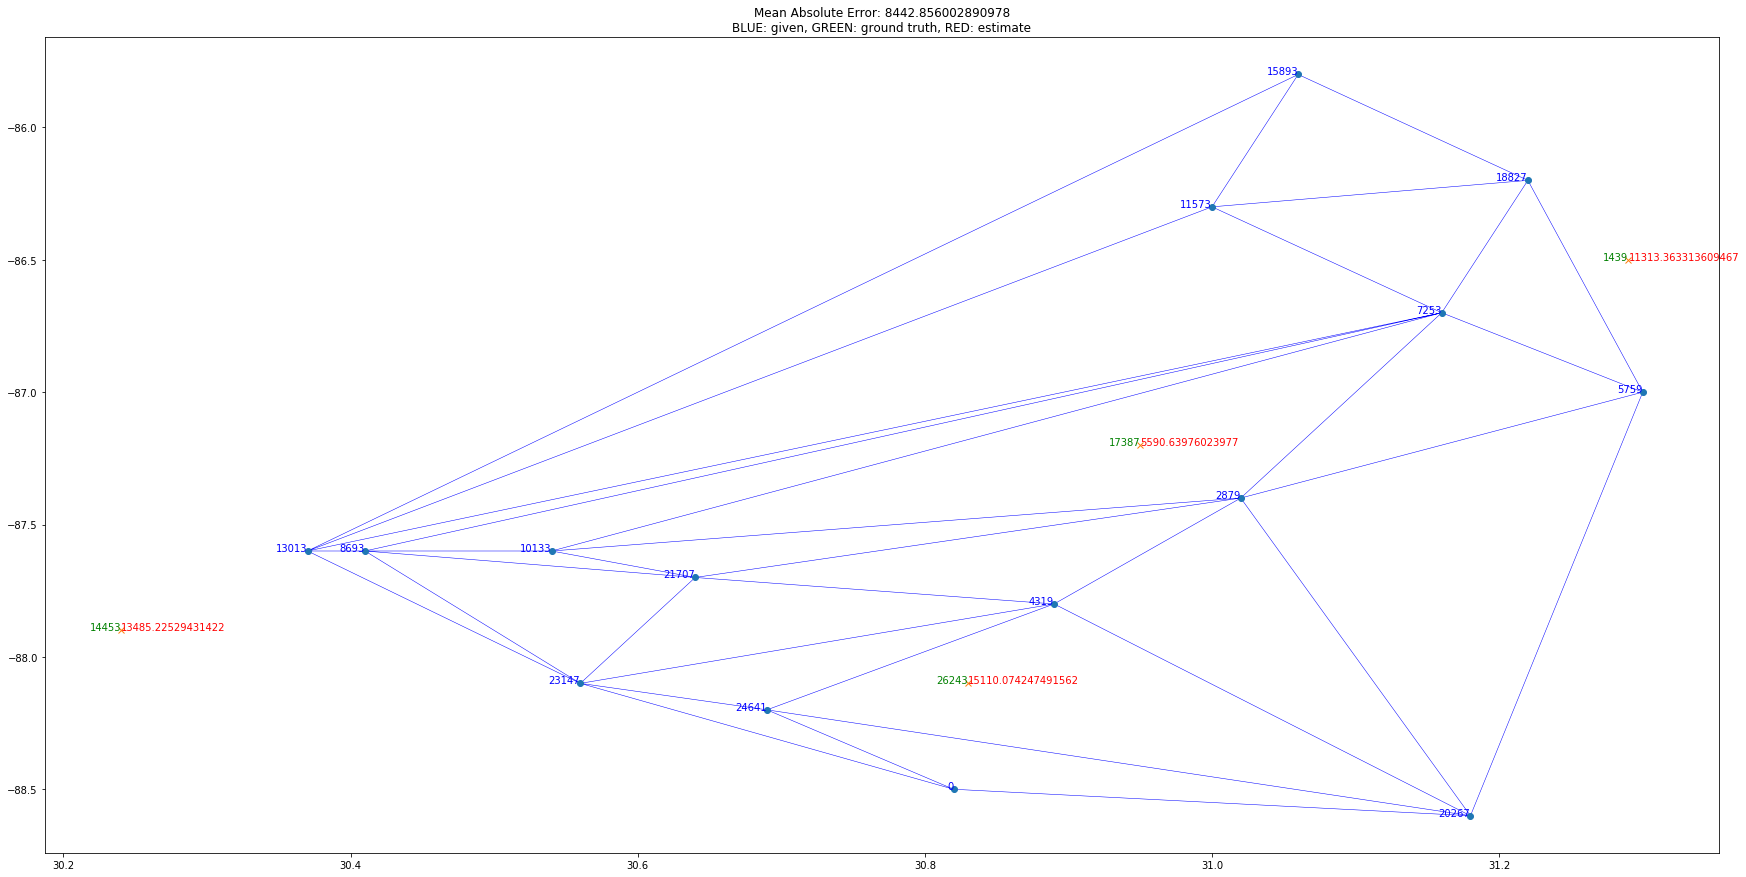

In [52]:
round_number = 0 # you can go from 0 to (n_folds * n_repeats)-1
plot_estimation(round_settings[round_number])

# Testing on Real Data
We now proceed to load the real dataset regarding to the 19 stations, including temperature measurements at different times. 

I've uploaded the file 'temperature.csv' on my github repository for easy loading on Google Colab.



In [0]:
# set the parameters for testing
time_point = 1 # [0, 22]
n_folds = 5
n_repeats = 5
imputer_type = 'knn' # 'knn, 'mean', or 'iterative' 

In [0]:
import pandas as pd
file_url = 'https://raw.githubusercontent.com/egebeyazit/mesonet/master/temperature.csv'
file_url2 = 'https://raw.githubusercontent.com/egebeyazit/mesonet/master/wind.csv'
df = pd.read_csv(file_url2, sep=',',header=0)
points = np.array(list(zip(df.lat, df.lon)))
values = np.array(df[str(time_point)])

In [56]:
#@title Run k-fold cross-validation by randomly removing some mesonets. Calculate the mean absolute error.

prediction_list = []
mae_list = []
round_settings = [] # all data to plot a round
counter = 0

for use_idx, pred_idx in rkf.split(points):
  use_coord, pred_coord = points[use_idx], points[pred_idx]
  use_val, pred_val = values[use_idx], values[pred_idx]
  grid = get_delaunay_grid(use_coord, use_val)
  grid[-1, 0] = 1e-10 # otherwise imputer truncates values
  grid[0, -1] = 1e-10

  imputer = get_imputer(imputer_type)
  imputer = imputer.fit(grid)
  full_grid = imputer.transform(grid)
  
  # for each pred coord
  predictions = []
  for pred in pred_coord:
    x_idx = min(range(len(grid_x[:,0])), key=lambda i: abs(grid_x[:,0][i]-pred[0]))
    y_idx = min(range(len(grid_y[0,:])), key=lambda i: abs(grid_y[0,:][i]-pred[1]))
    predictions.append(full_grid[x_idx, y_idx])

  # calculate the mean absolute error for the fold
  mae = mean_absolute_error(pred_val, predictions)
  mae_list.append(mae)
  # save data to plot
  round_settings.append({
      'round': counter,
      'given_coordinates': use_coord,
      'given_values': use_val,
      'estimated_coordinates': pred_coord,
      'ground_truths': pred_val,
      'estimations': predictions,
      'mae': mae
  })

print("Mean absolute error over " +str(n_folds*n_repeats) + " random trials w/ " + str(imputer_type) + " imputer: " + str(np.mean(mae_list)))

Mean absolute error over 25 random trials w/ knn imputer: 1.6933366551359956


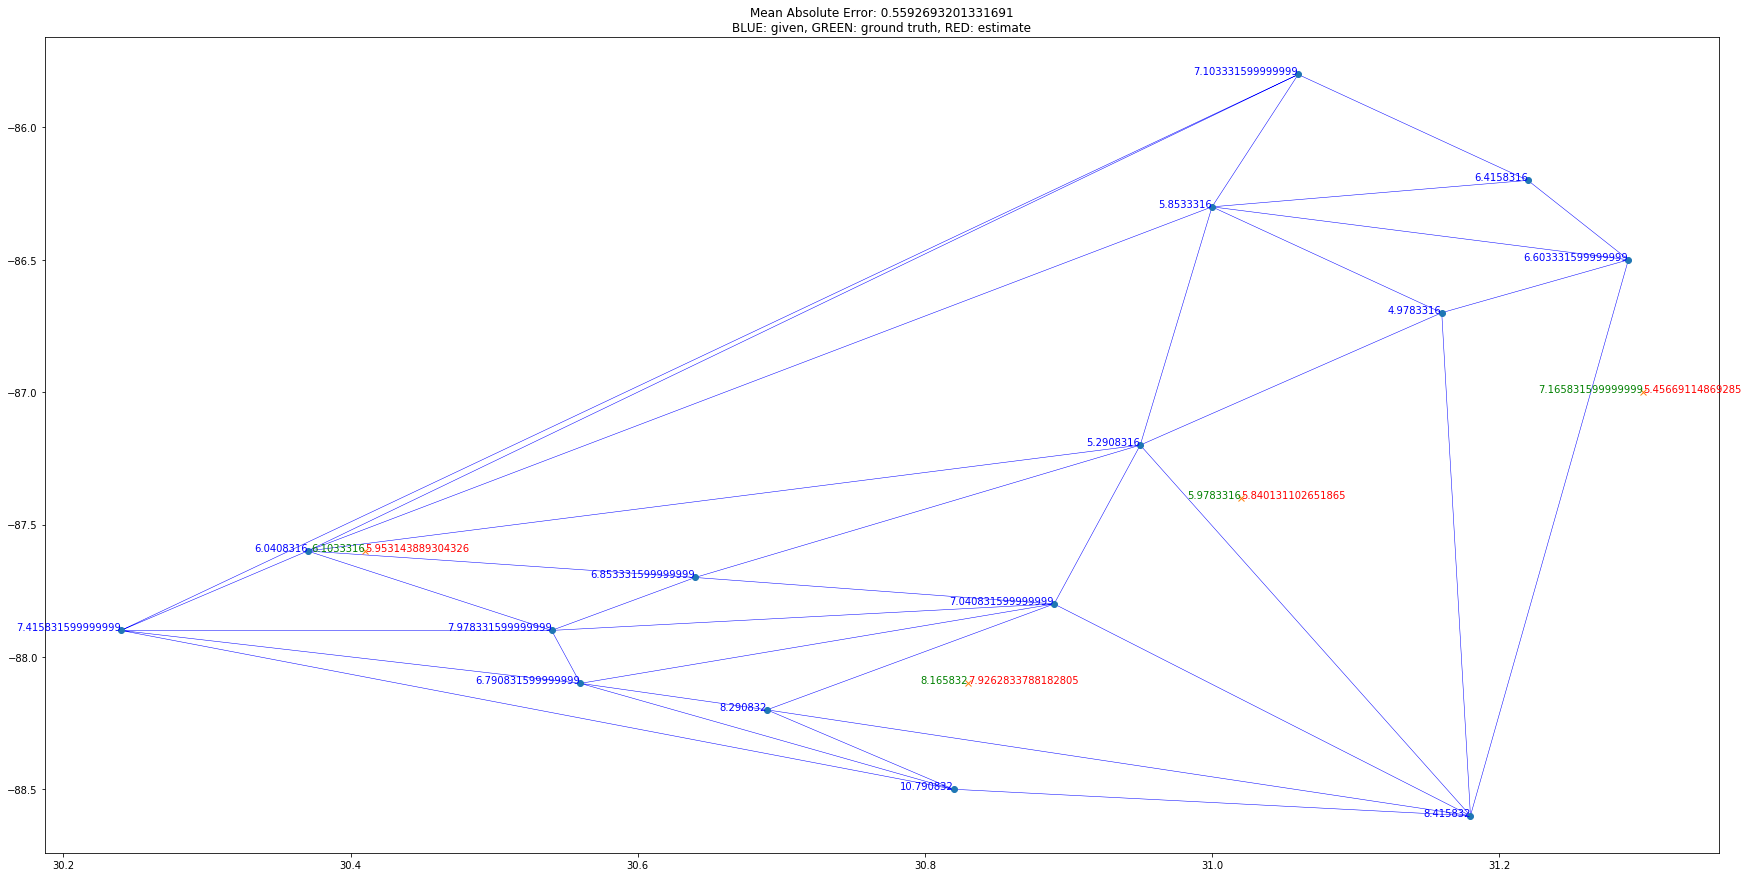

In [57]:
# visualize
round_number = 0 # you can go from 0 to (n_folds * n_repeats)-1
plot_estimation(round_settings[round_number])

# Working on 3D Data (Incorporating Elevation) - without unit adjustment
In this section, we use the SRTM dataset to extract the height information for given Mesonets.

We then combine the height information with the triangulation to achieve 3D interpolation.

In [58]:
#@title Load the elevation data for the 19 coordinates.
import os
import math
import numpy
import struct

!wget https://raw.githubusercontent.com/egebeyazit/mesonet/master/SRTM3.zip
!unzip SRTM3.zip

--2020-01-02 22:51:28--  https://raw.githubusercontent.com/egebeyazit/mesonet/master/SRTM3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15089361 (14M) [application/zip]
Saving to: ‘SRTM3.zip.1’

SRTM3.zip.1         100%[===================>]  14.39M  --.-KB/s    in 0.08s   

2020-01-02 22:51:28 (189 MB/s) - ‘SRTM3.zip.1’ saved [15089361/15089361]

Archive:  SRTM3.zip
replace SRTM3/N30W085.hgt? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [0]:
#@title Define utility functions to read height values for given coordinates from .hgt files.

import os
import json
import numpy as np

# https://librenepal.com/article/reading-srtm-data-with-python/

SAMPLES = 1201  # Change this to 3601 for SRTM1
HGTDIR = './SRTM3'  # All 'hgt' files will be kept here uncompressed


def get_elevation(lat, lon):
    hgt_file = get_file_name(lon, lat)
    if hgt_file:
        return read_elevation_from_file(hgt_file, lon, lat)
    return -32768


def read_elevation_from_file(hgt_file, lon, lat):
    with open(hgt_file, 'rb') as hgt_data:
        elevations = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES*SAMPLES)\
                                .reshape((SAMPLES, SAMPLES))
        lat_row = int(round((lat - int(lat)) * (SAMPLES - 1), 0))
        lon_row = int(round((lon - int(lon)) * (SAMPLES - 1), 0))

        return elevations[SAMPLES - 1 - lat_row, lon_row].astype(int)

def get_file_name(lon, lat):
    if lat >= 0:
        ns = 'N'
    elif lat < 0:
        ns = 'S'

    if lon >= 0:
        ew = 'E'
    elif lon < 0:
        ew = 'W'

    hgt_file = "%(ns)s%(lat)02d%(ew)s%(lon)03d.hgt" % {'lat': abs(lat), 'lon': abs(lon), 'ns': ns, 'ew': ew}
    hgt_file_path = os.path.join(HGTDIR, hgt_file)
    if os.path.isfile(hgt_file_path):
        return hgt_file_path
    else:
        return None

In [0]:
#@title Fetch and record the elevation for each station.
get_elevation(30.82, -88.5)
points_3d = []
for point in points:
  elevation = get_elevation(point[0], point[1])
  points_3d.append(np.array([point[0], point[1], elevation]))
points_3d = np.array(points_3d)

Let us take a look at our 3-dimensional coordinates now. 

As you can see below, the distance between the points (in terms of degree and minutes) has a different scale than height difference between the points. I am concerned that this would mess the triangulation up. Let us see.

In [61]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
df = pd.DataFrame(data=points_3d)
df.columns = ['Latitude', 'Longitude', 'Height']
print(df)

    Latitude  Longitude  Height
0      30.82      -88.5    66.0
1      31.29      -86.5   101.0
2      31.02      -87.4    96.0
3      30.89      -87.8    62.0
4      31.30      -87.0    77.0
5      31.16      -86.7    63.0
6      30.41      -87.6    13.0
7      30.54      -87.9    46.0
8      31.00      -86.3    44.0
9      30.37      -87.6     0.0
10     30.24      -87.9     0.0
11     31.06      -85.8    47.0
12     30.95      -87.2    67.0
13     31.22      -86.2    78.0
14     31.18      -88.6    79.0
15     30.64      -87.7    26.0
16     30.56      -88.1    16.0
17     30.69      -88.2    55.0
18     30.83      -88.1    66.0


In [0]:
#@title Define 3d visualization function for Delaunay.

def plot_tri(ax, points, tri):
    for tr in tri.simplices:
        pts = points[tr, :]
        ax.plot3D(pts[[0,1],0], pts[[0,1],1], pts[[0,1],2], color='g', lw='0.1')
        ax.plot3D(pts[[0,2],0], pts[[0,2],1], pts[[0,2],2], color='g', lw='0.1')
        ax.plot3D(pts[[0,3],0], pts[[0,3],1], pts[[0,3],2], color='g', lw='0.1')
        ax.plot3D(pts[[1,2],0], pts[[1,2],1], pts[[1,2],2], color='g', lw='0.1')
        ax.plot3D(pts[[1,3],0], pts[[1,3],1], pts[[1,3],2], color='g', lw='0.1')
        ax.plot3D(pts[[2,3],0], pts[[2,3],1], pts[[2,3],2], color='g', lw='0.1')

    ax.scatter(points[:,0], points[:,1], points[:,2], color='b')
    return ax

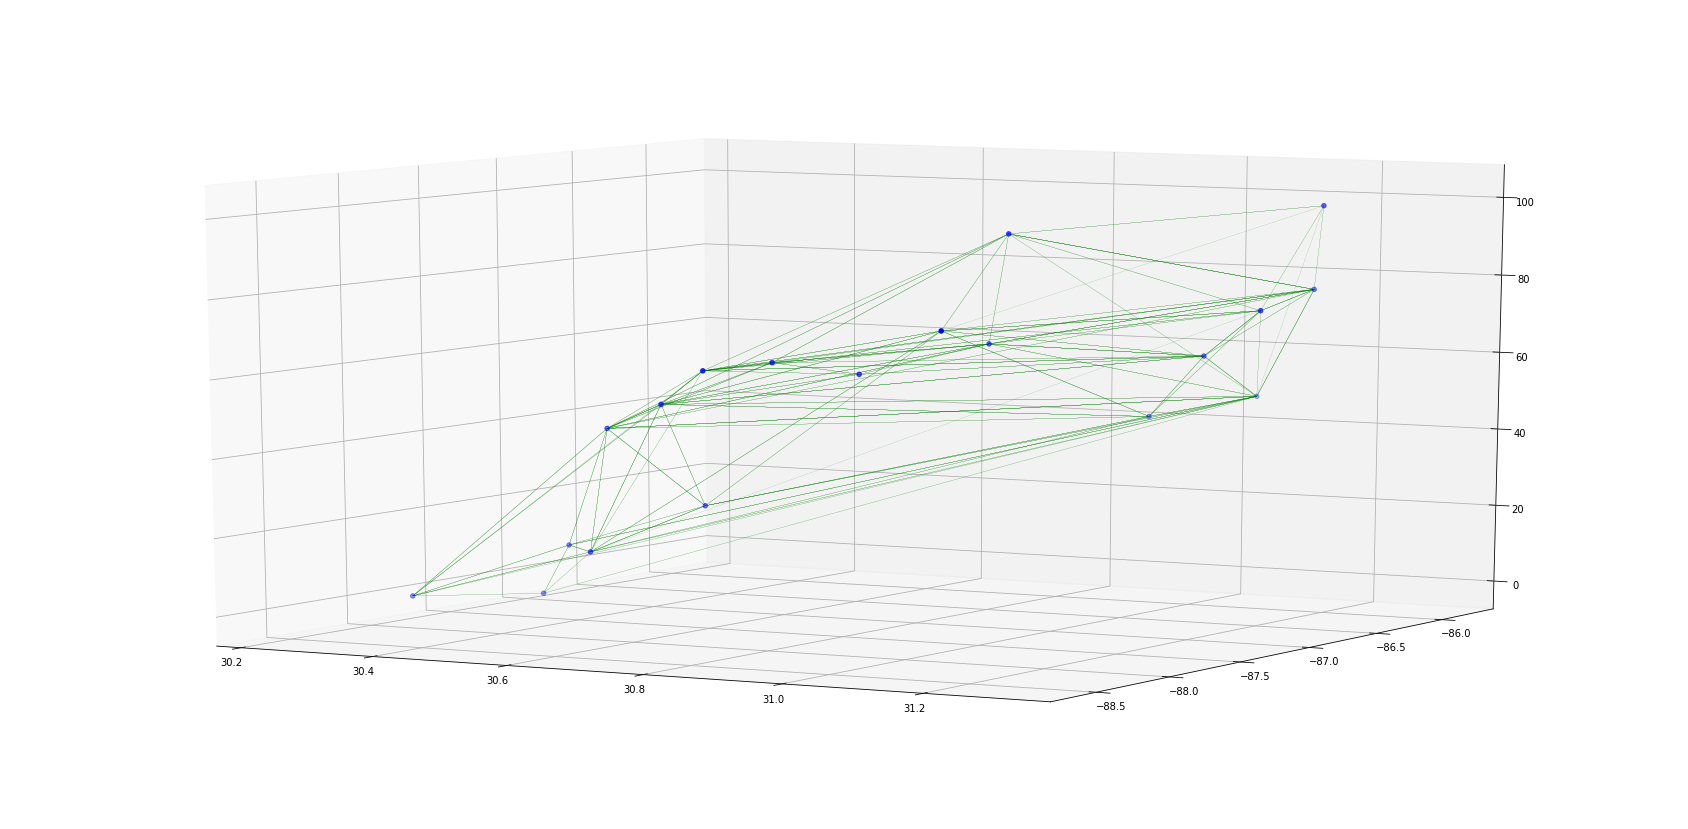

In [63]:
# set the view angle and plot
tri = Delaunay(points_3d, incremental=True)
view_angle = 10
fig = plt.figure(figsize=fig_size)
ax = plt.axes(projection='3d')
ax.view_init(view_angle)
ax = plot_tri(ax, points_3d, tri)

In [64]:
#@title Fit the triangulation on 3D grid by interpolating.
grid_size  = [5, 13, 10]
df.columns = ['X', 'Y', 'Z']
x_range, y_range, z_range = df.X.max() - df.X.min(), df.Y.max() - df.Y.min(), df.Z.max() - df.Z.min()
print('Ranges of X, Y, Z dimensions: '+ str(x_range) + ', ' + str(y_range) + ', ' + str(z_range))
grid_x, grid_y, grid_z = np.mgrid[df.X.min():df.X.max():(x_range/float(grid_size[0])), 
                          df.Y.min():df.Y.max():(y_range/float(grid_size[1])),
                          df.Z.min():df.Z.max():(z_range/float(grid_size[2])),
                          ]

# use normalized data for interpolation, then upscale
df['val'] = values
norm = np.linalg.norm(values)
norm_values = values / norm
df['norm_val'] = norm_values
#points, values = df[['X','Y','Z']].values, df['norm_val'].values 
points, values = df[['X','Y','Z']].values, df['val'].values 

# interpolate onto the grid. method='nearest' or 'cubic' are other options
grid_linear = griddata(points, values, (grid_x, grid_y, grid_z), method='linear', rescale=False)

Ranges of X, Y, Z dimensions: 1.0600000000000023, 2.799999999999997, 101.0


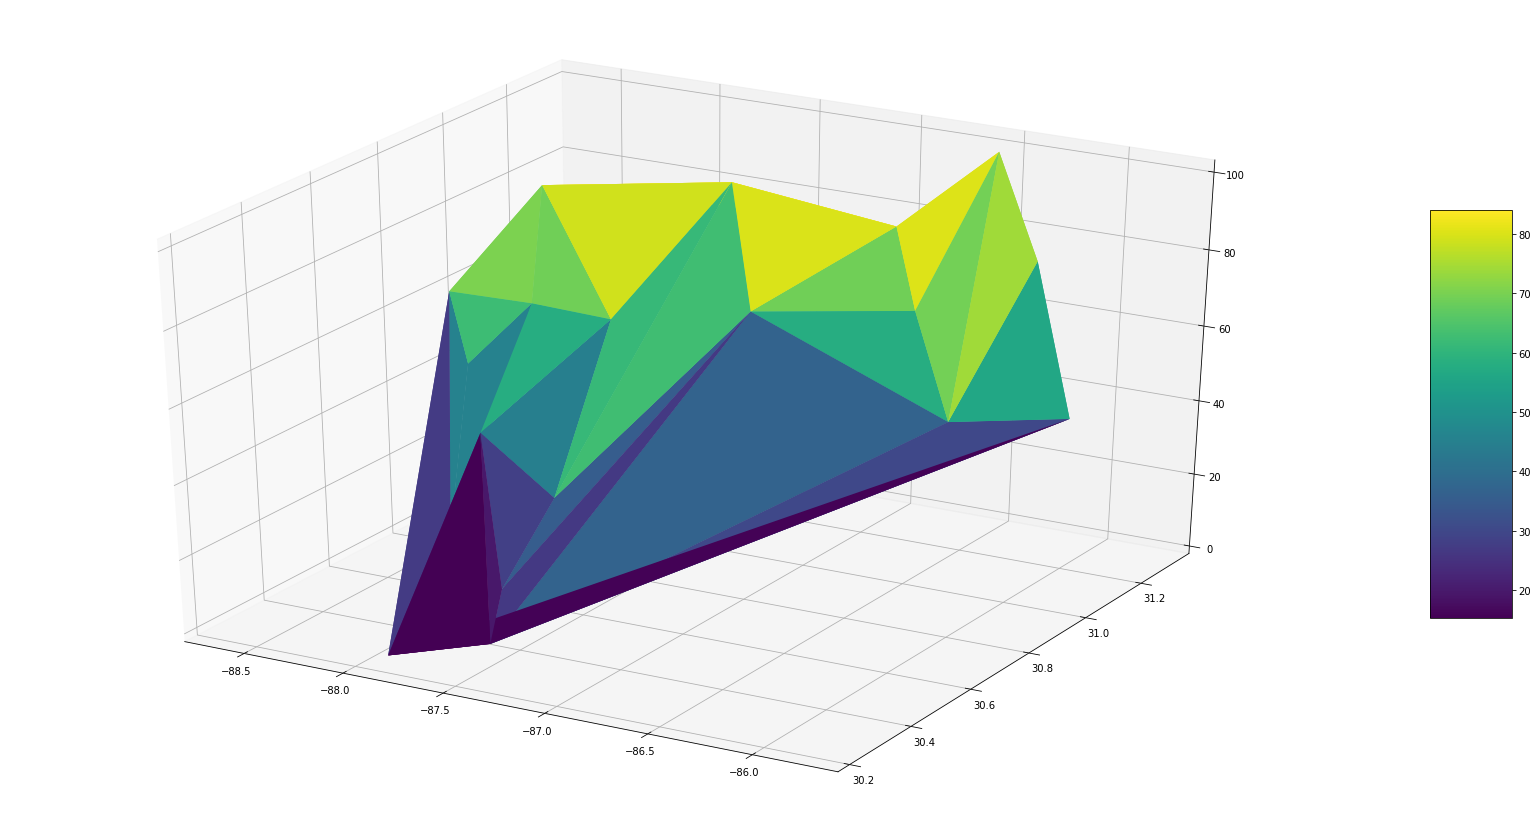

In [65]:
#@title Plot the 3D mesh (interpolated triangulation).
# Make the plot
fig = plt.figure(figsize=fig_size)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2 )

# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)

In [66]:
#@title Transform 3D data to a dataframe of 4 features: [x,y,z,val].
dataset = []
for x in range(grid_linear.shape[0]):
  for y in range(grid_linear.shape[1]):
    for z in range(grid_linear.shape[2]):
      dataset.append(np.array([grid_x[x,0,0], grid_y[0,y,0], grid_z[0,0,z], grid_linear[x,y,z]]))
dataset = np.array(dataset)
len(dataset) == grid_size[0] * grid_size[1] * grid_size[2]
dataset = pd.DataFrame(data=dataset)
dataset.columns = ['X', 'Y', 'Z', 'value']
non_null = dataset.loc[dataset.value.notnull()]
print('Dataset size: ' + str(dataset.shape))
print('Non-null ratio: ' + str(float(len(non_null))/len(dataset)))
print('Non-null entries')
print(non_null)

Dataset size: (650, 4)
Non-null ratio: 0.11076923076923077
Non-null entries
          X          Y     Z     value
161  30.452 -87.953846  10.1  6.786243
162  30.452 -87.953846  20.2  7.295099
163  30.452 -87.953846  30.3  7.953386
171  30.452 -87.738462  10.1  6.312773
172  30.452 -87.738462  20.2  6.643217
..      ...        ...   ...       ...
616  31.088 -86.661538  60.6  5.516915
617  31.088 -86.661538  70.7  5.851165
626  31.088 -86.446154  60.6  5.945539
627  31.088 -86.446154  70.7  6.629526
636  31.088 -86.230769  60.6  6.460706

[72 rows x 4 columns]


An important thing to notice here is, now that we are in a 3D space now, the number of null value locations we have has increased. Therefore, first mapping onto a 2D space, then imputing the null values would probably be better.

In [67]:
from sklearn.linear_model import Ridge
# try ridge regression for predicting nans
dataset['XY'] = dataset['Y'] * dataset['X']
dataset['XZ'] = dataset['Z'] * dataset['X']
dataset['YZ'] = dataset['Z'] * dataset['Y']
dataset['X^2'] = dataset['X'] * dataset['X']
dataset['Y^2'] = dataset['Y'] * dataset['Y']
dataset['Z^2'] = dataset['Z'] * dataset['Z']
non_null = dataset.loc[dataset.value.notnull()]
X = non_null[['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'X^2', 'Y^2', 'Z^2']].values
y = non_null['value'].values
reg = Ridge(alpha=0.001, normalize=True).fit(X, y)
reg.score(X, y)

0.5825165642155493

In [68]:
# try MLP for predicting nans
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(hidden_layer_sizes=(50, 50, 20),
                                 tol=1e-4, max_iter=1000, random_state=0, activation='tanh'))
mlp.fit(X, y)
mlp.score(X, y)

#null = dataset[dataset.isnull().any(axis=1)]
#X = null[['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'X^2', 'Y^2', 'Z^2']].values
#mlp.predict(X)

0.7505609457271718

# Working on 3D Data by Adjusting the Units
By using the coordinates as features together with elevation (meters), we are introducing some bias to the models we work with. 

A quick and dirty fix is converting the unit of the elevation data to degrees.
We assume 1 degree is 111132 meters.

In [0]:
#@title Set the 3d grid size here.

grid_size  = [5, 13, 4]

In [78]:
get_elevation(30.82, -88.5)
points_3d = []
for point in points:
  elevation = get_elevation(point[0], point[1])
  points_3d.append(np.array([point[0], point[1], elevation]))
points_3d = np.array(points_3d)
points_3d[:, 2] = points_3d[:, 2] / 111132.0
df = pd.DataFrame(data=points_3d)
df.columns = ['Latitude', 'Longitude', 'Height']
print(df)
#@title Fit the triangulation on 3D grid by interpolating.
df.columns = ['X', 'Y', 'Z']
x_range, y_range, z_range = df.X.max() - df.X.min(), df.Y.max() - df.Y.min(), df.Z.max() - df.Z.min()
print('Ranges of X, Y, Z dimensions: '+ str(x_range) + ', ' + str(y_range) + ', ' + str(z_range))
grid_x, grid_y, grid_z = np.mgrid[df.X.min():df.X.max():(x_range/float(grid_size[0])), 
                          df.Y.min():df.Y.max():(y_range/float(grid_size[1])),
                          df.Z.min():df.Z.max():(z_range/float(grid_size[2])),
                          ]

# use normalized data for interpolation, then upscale
df['val'] = values
norm = np.linalg.norm(values)
norm_values = values / norm
df['norm_val'] = norm_values
#points, values = df[['X','Y','Z']].values, df['norm_val'].values 
points, values = df[['X','Y','Z']].values, df['val'].values 

# interpolate onto the grid. method='nearest' or 'cubic' are other options
grid_linear = griddata(points, values, (grid_x, grid_y, grid_z), method='linear', rescale=False)

    Latitude  Longitude    Height
0      30.82      -88.5  0.000594
1      31.29      -86.5  0.000909
2      31.02      -87.4  0.000864
3      30.89      -87.8  0.000558
4      31.30      -87.0  0.000693
5      31.16      -86.7  0.000567
6      30.41      -87.6  0.000117
7      30.54      -87.9  0.000414
8      31.00      -86.3  0.000396
9      30.37      -87.6  0.000000
10     30.24      -87.9  0.000000
11     31.06      -85.8  0.000423
12     30.95      -87.2  0.000603
13     31.22      -86.2  0.000702
14     31.18      -88.6  0.000711
15     30.64      -87.7  0.000234
16     30.56      -88.1  0.000144
17     30.69      -88.2  0.000495
18     30.83      -88.1  0.000594
Ranges of X, Y, Z dimensions: 1.0600000000000023, 2.799999999999997, 0.0009088291401216571


In [79]:
#@title Measuring the regression score after rescaling the units.
dataset = []
for x in range(grid_linear.shape[0]):
  for y in range(grid_linear.shape[1]):
    for z in range(grid_linear.shape[2]):
      dataset.append(np.array([grid_x[x,0,0], grid_y[0,y,0], grid_z[0,0,z], grid_linear[x,y,z]]))
dataset = np.array(dataset)
len(dataset) == grid_size[0] * grid_size[1] * grid_size[2]
dataset = pd.DataFrame(data=dataset)
dataset.columns = ['X', 'Y', 'Z', 'value']
non_null = dataset.loc[dataset.value.notnull()]

dataset['XY'] = dataset['Y'] * dataset['X']
dataset['XZ'] = dataset['Z'] * dataset['X']
dataset['YZ'] = dataset['Z'] * dataset['Y']
dataset['X^2'] = dataset['X'] * dataset['X']
dataset['Y^2'] = dataset['Y'] * dataset['Y']
dataset['Z^2'] = dataset['Z'] * dataset['Z']
non_null = dataset.loc[dataset.value.notnull()]
X = non_null[['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'X^2', 'Y^2', 'Z^2']].values
y = non_null['value'].values
reg = Ridge(alpha=0.001, normalize=True).fit(X, y)
reg.score(X, y)

0.6718676148602685

In [80]:
#@title Define a MLP that overfits the existing data.
# try MLP for predicting nans
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(hidden_layer_sizes=(50, 50, 20),
                                 tol=1e-4, max_iter=1000, random_state=0, activation='relu'))
mlp.fit(X, y)
print(mlp.score(X, y))

null = dataset[dataset.isnull().any(axis=1)]
X = null[['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'X^2', 'Y^2', 'Z^2']].values
y = mlp.predict(X)

0.9484798966685998


In [81]:
#@title Fill the missing values using MLP.
# complete the null values
predictions = pd.DataFrame(data=X)
predictions.columns = ['X', 'Y', 'Z', 'XY', 'XZ', 'YZ', 'X^2', 'Y^2', 'Z^2']
predictions['value'] = y
complete = non_null.append(predictions, sort=True)
complete

,X,XY,XZ,X^2,Y,YZ,Y^2,Z,Z^2,value
65,30.452,-2678.370523,0.006919,927.324304,-87.953846,-0.019984,7735.879053,0.000227,5.162315e-08,7.569922
69,30.452,-2671.811631,0.006919,927.324304,-87.738462,-0.019935,7698.037633,0.000227,5.162315e-08,6.935368
114,30.664,-2703.621292,0.013934,940.280896,-88.169231,-0.040065,7773.813254,0.000454,2.064926e-07,8.136556
117,30.664,-2697.016738,0.006967,940.280896,-87.953846,-0.019984,7735.879053,0.000227,5.162315e-08,6.880932
118,30.664,-2697.016738,0.013934,940.280896,-87.953846,-0.039968,7735.879053,0.000454,2.064926e-07,7.781619
...,...,...,...,...,...,...,...,...,...,...
224,31.088,-2680.742154,0.021190,966.463744,-86.230769,-0.058777,7435.745562,0.000682,4.646084e-07,7.489882
225,31.088,-2674.046277,0.000000,966.463744,-86.015385,-0.000000,7398.646391,0.000000,0.000000e+00,9.921829
226,31.088,-2674.046277,0.007063,966.463744,-86.015385,-0.019543,7398.646391,0.000227,5.162315e-08,9.382455
227,31.088,-2674.046277,0.014127,966.463744,-86.015385,-0.039087,7398.646391,0.000454,2.064926e-07,8.475313


In [0]:
#@title Get the 2D slice from the predicted values where the elevation = 0.
# get the slice at elevation 0
no_elevation = complete[complete['Z'] == 0]

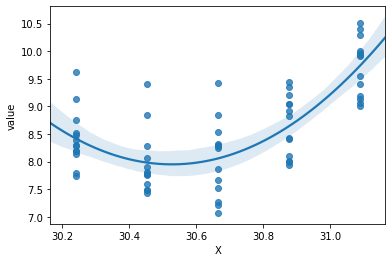

In [83]:
#@title See how X coordinate correlates with the measurement.
sns.regplot(x="X", y="value", data=no_elevation, order=2);

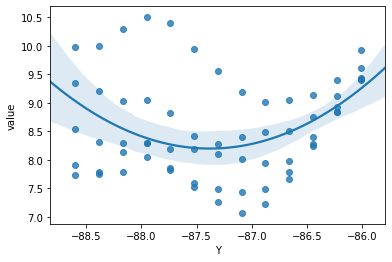

In [84]:
#@title See how Y coordinate correlates with the measurement,
sns.regplot(x="Y", y="value", data=no_elevation, order=2);

In [0]:
#@title Map the coordinate based data back to grid.
X_list = no_elevation.X.unique()
Y_list = no_elevation.Y.unique()
grid = np.zeros((len(X_list), len(Y_list)))

i = 0
for X in X_list:
  j = 0
  for Y in Y_list:
    grid[i,j] = (no_elevation.loc[(no_elevation['X'] == X) & (no_elevation['Y'] == Y)])['value'].values[0]
    j += 1
  i += 1

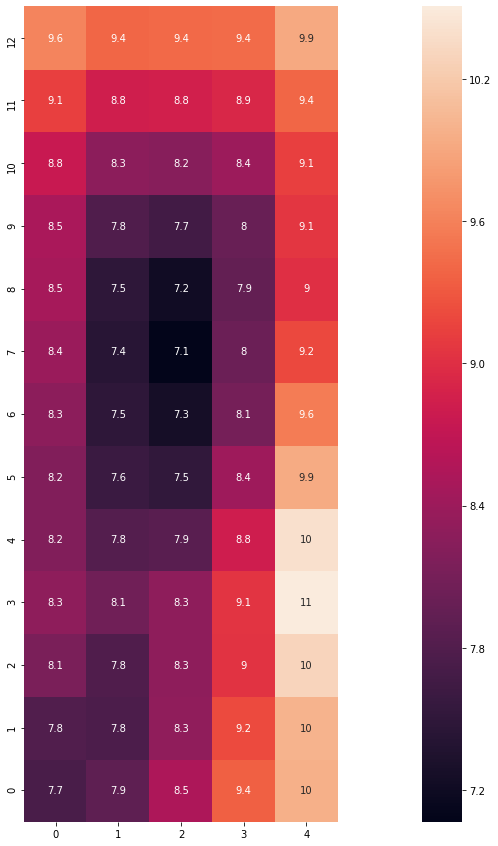

In [86]:
#@title Plot the input to be fed to the Conv-LSTM.
fig, ax = plt.subplots(figsize=fig_size)
sns.heatmap(grid.T, annot=True, ax = ax, square=True)
ax.invert_yaxis() # heatmap reverses the y axis automatically, fix it with this

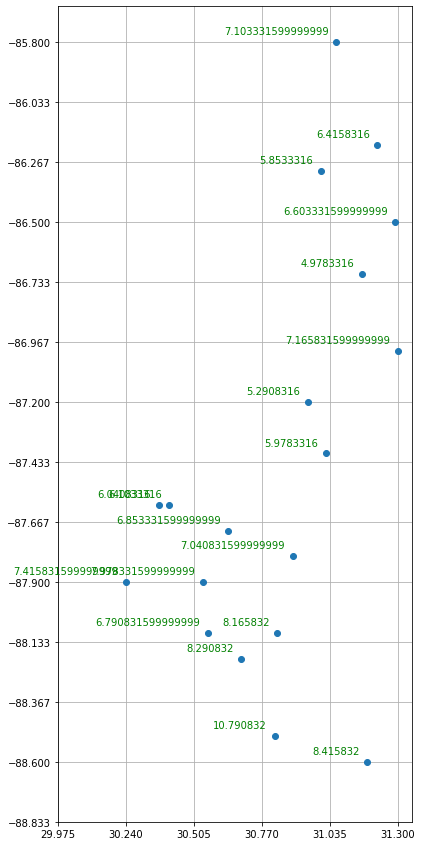

In [87]:
df = pd.read_csv(file_url2, sep=',',header=0)
points = np.array(list(zip(df.lat, df.lon)))
values = np.array(df[str(time_point)])
df = no_elevation

fig = plt.figure(figsize=fig_size) # 12 x 7 
ax = fig.add_subplot(1, 1, 1)

ax.plot(points[:,0], points[:,1], 'o')

for j, p in enumerate(points):
  plt.text(p[0]-0.03, p[1]+0.03, values[j], ha='right', size=10, color='green') # label the points with values

# Add the grid
x_ticks = np.arange(df.X.min() - (x_range/(grid_size[0] - 1)), df.X.max() + (x_range/(grid_size[0] - 1)), (x_range/(grid_size[0] - 1)))
y_ticks = np.arange(df.Y.min() - (y_range/(grid_size[1] - 1)), df.Y.max() + (y_range/(grid_size[1] - 1)), (y_range/(grid_size[1] - 1)))
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_aspect('equal')
ax.grid()
plt.show()